# II - Accessing Astronomical Data From Python

## 0.- Installing necessary packages
* ``conda install astropy``
* ``conda install -c astropy aplpy astroquery``

Before doing to data analysis, we need to find, load and pre-process data!

## 1.- Astronomical Data from WebPages

Function to retrieve the tarball and the fits file.

In [1]:
import os
import urllib
import tarfile
import sys
#%matplotlib inline
%matplotlib notebook
global DOWNLOADS_DIR 
DOWNLOADS_DIR= '.'

def download_and_extract(url):
    # Obtain the filename
    name = url.rsplit('/', 1)[-1]
    filename = os.path.join(DOWNLOADS_DIR, name)
    # Download the file if not found
    if not os.path.isfile(filename):
        urllib.urlretrieve(url, filename)
    # Decompress (if needed) and copy the selected file to the DOWNLOADS_DIR
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    if not os.path.isdir(sdir):
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()

In [2]:
# Data from ALMA science verification 
twhydra_url = 'https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz'
download_and_extract(twhydra_url)

!ls TWHYA_BAND7_ReferenceImages

TWHydra_CO3_2line.image.fits
TWHydra_CO3_2line.image.mom.weighted_coord.fits
TWHydra_CO3_2line.image.mom.weighted_dispersion_coord.fits
TWHydra_CO3_2line.image.mom0.fits
TWHydra_HCOplusline.image.fits
TWHydra_HCOplusline.image.mom.weighted_coord.fits
TWHydra_HCOplusline.image.mom.weighted_dispersion_coord.fits
TWHydra_HCOplusline.image.mom0.fits
TWHydra_contall_apcal.image.fits


## 2.- Loading and a Quick Look at the Data

In [3]:
from astropy.io import fits
import logging
import warnings
warnings.filterwarnings('ignore')

# Load File
hdulist = fits.open("TWHYA_BAND7_ReferenceImages/TWHydra_CO3_2line.image.mom0.fits")
twhydra = hdulist[0]
import astropy
astropy.version.version

'2.0'

### Show the header

In [62]:
twhydra.header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   4.668472210566E-04                                                  
BMIN    =   4.255372948117E-04                                                  
BPA     =   2.230152130127E+01                                                  
BTYPE   = 'Intensity'       

### Quick Look
We can use matplotlib

<IPython.core.display.Javascript object>


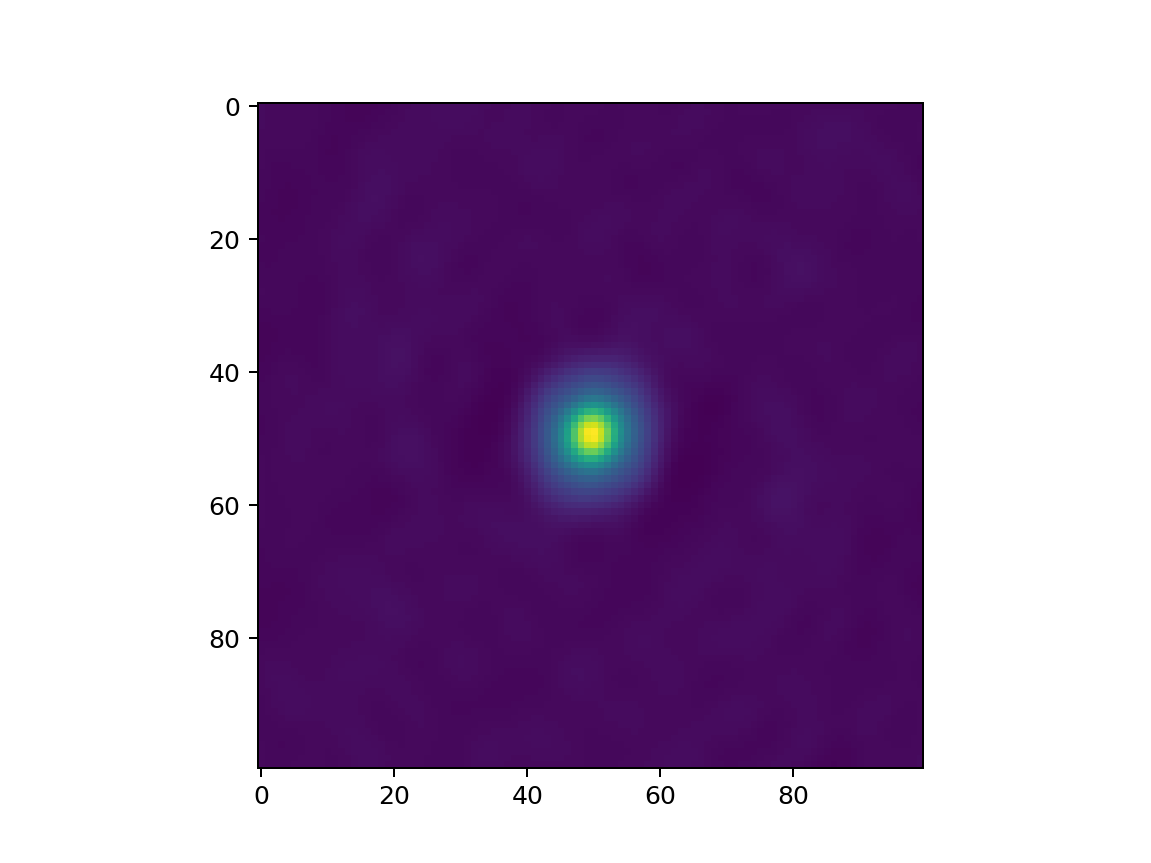

In [4]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(twhydra.data.sum(axis=(0,1)))
#plt.show()

INFO: Setting slices=[0, 0] [aplpy.core]


<IPython.core.display.Javascript object>


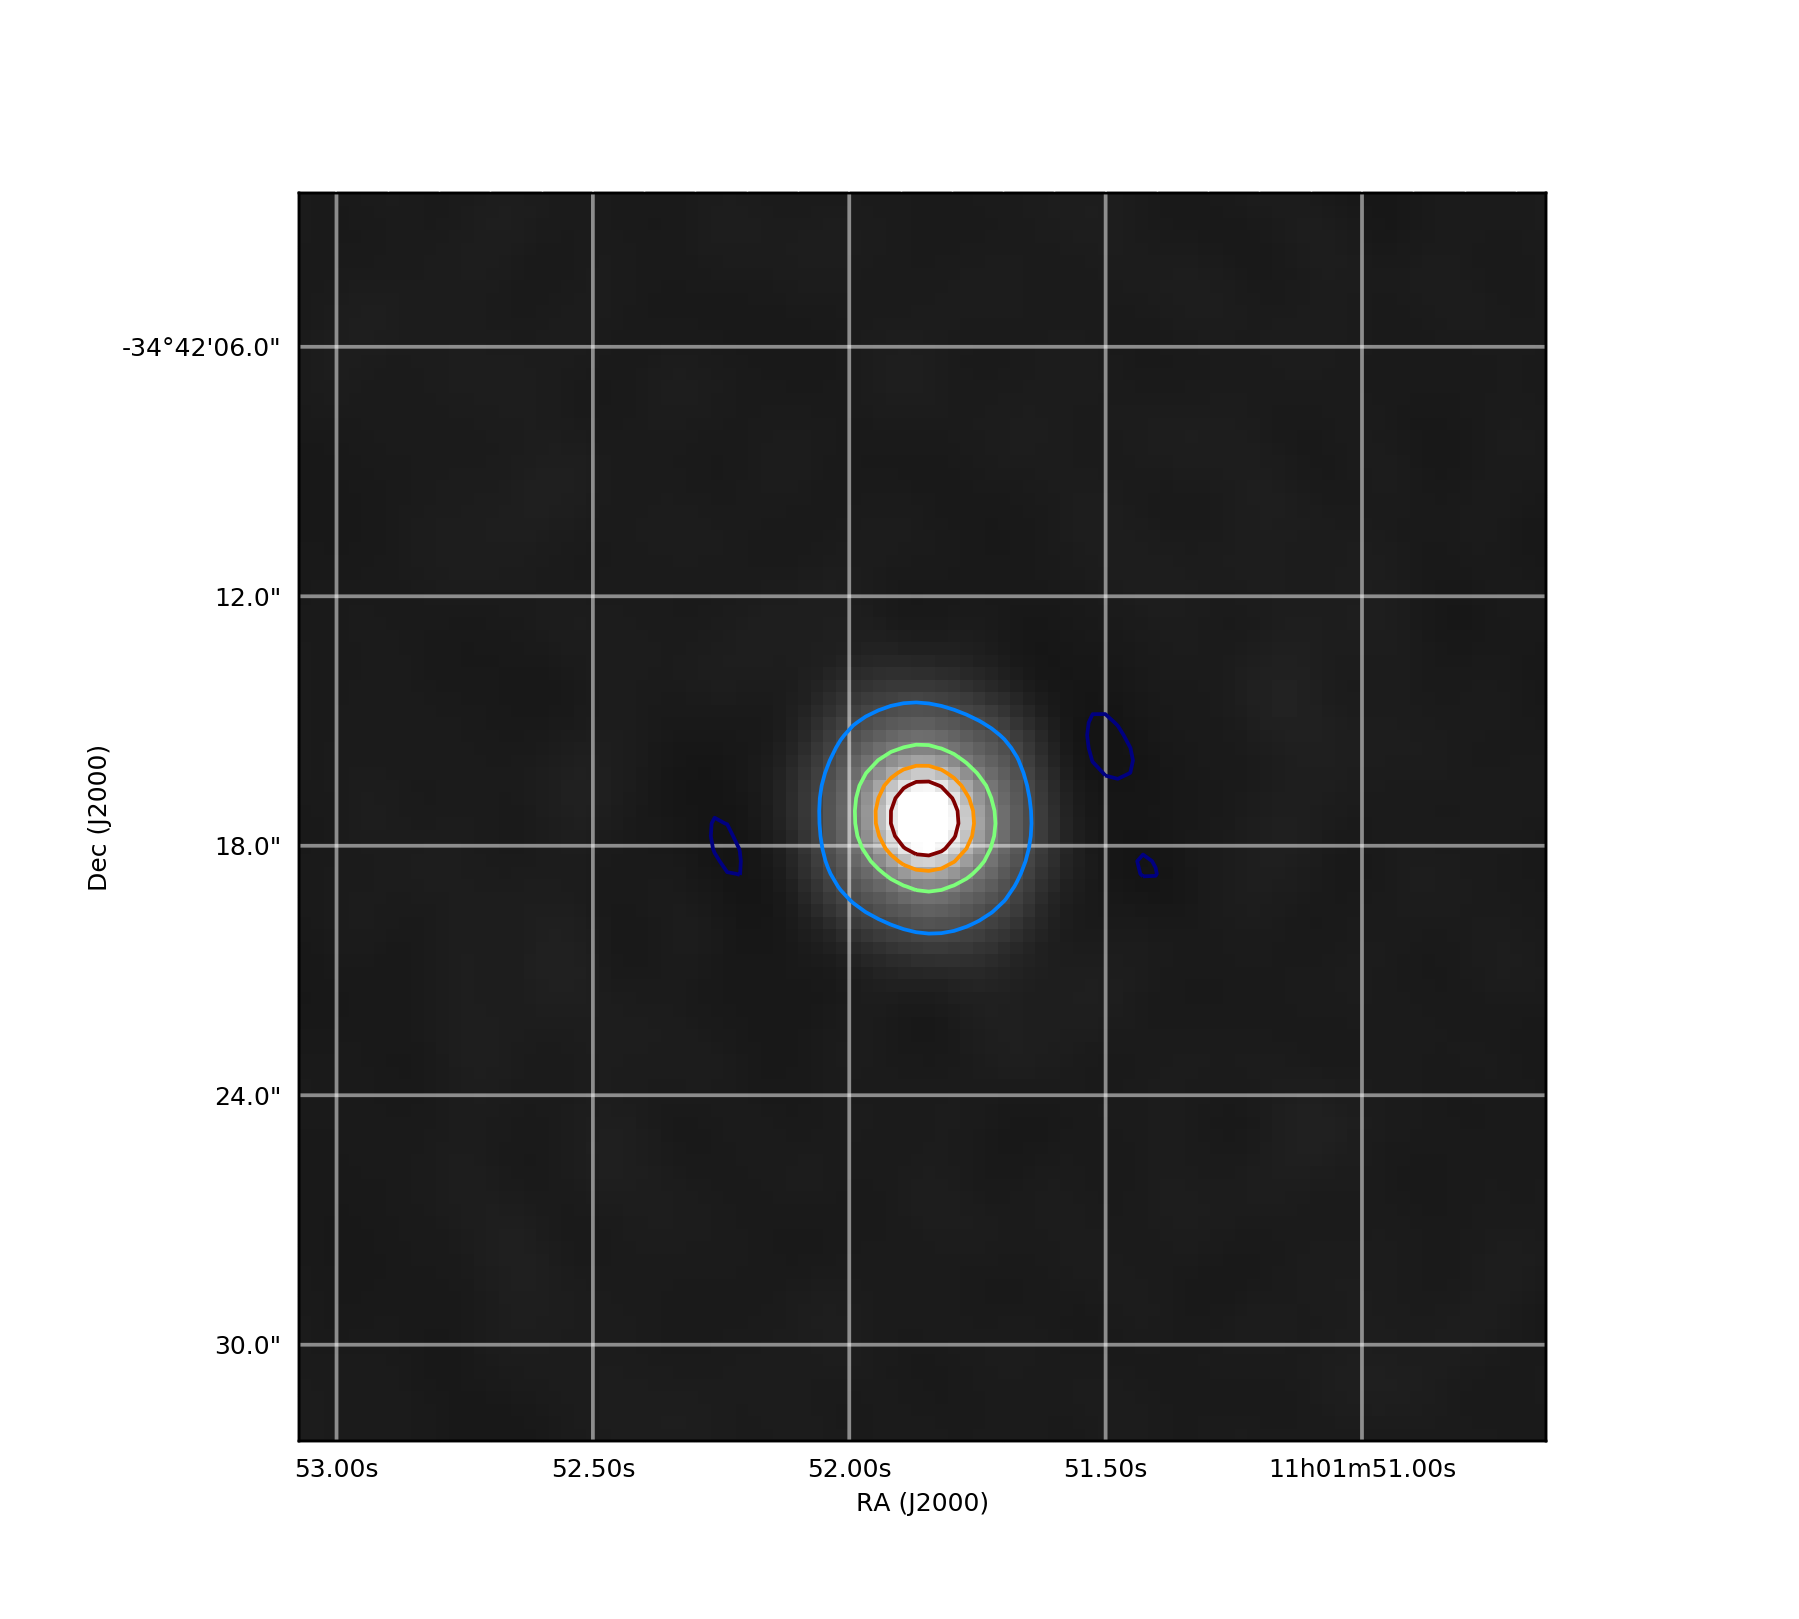

INFO: Auto-setting vmin to -9.227e-01 [aplpy.core]
INFO: Auto-setting vmax to  7.636e+00 [aplpy.core]


In [5]:
import aplpy 
fig = aplpy.FITSFigure(twhydra)
fig.show_grayscale()
fig.show_grid()
fig.show_contour()

<IPython.core.display.Javascript object>


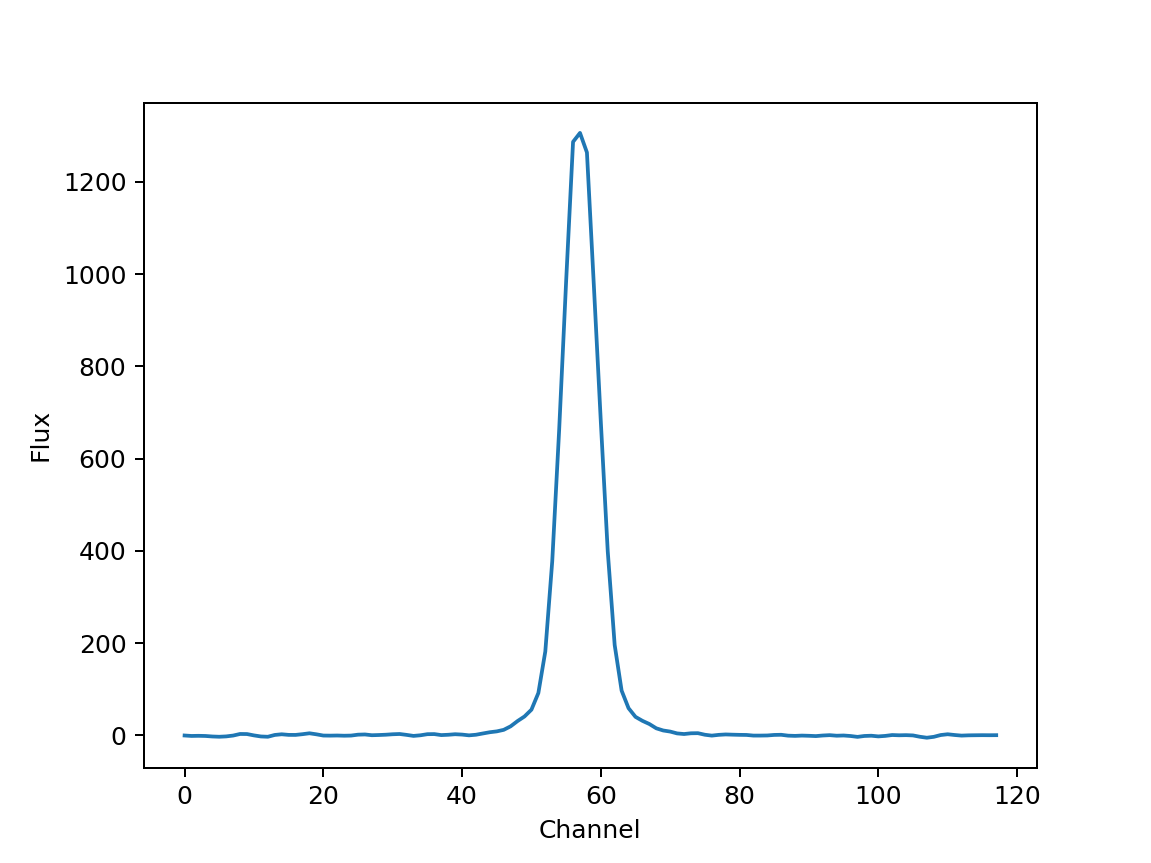

In [6]:
#Load Data Cube
hdulist = fits.open("TWHYA_BAND7_ReferenceImages/TWHydra_CO3_2line.image.fits")
twhydra_cube = hdulist[0]

def show_spectra(cube):
    spec = cube.sum(axis=(0,2,3))
    plt.plot(spec)
    plt.ylabel('Flux')
    plt.xlabel('Channel')

show_spectra(twhydra_cube.data)
#plt.show()

## Interactivity

In [7]:
import ipywidgets
from ipywidgets import interact
threshold=0.
print(type(threshold))
ipywidgets.__version__

<class 'float'>


'7.0.0'

In [8]:
mmax = twhydra_cube.data.max()
mmin = twhydra_cube.data.min()
print(mmax,mmin)
interact?

8.64718 -0.488696


In [10]:
%matplotlib inline
#@interact.options(manual=True)
def interactive_denoising(threshold=0.):
    threshold=float(threshold)
    #print type(threshold)
    cube=twhydra_cube.data.copy()
    cube[cube < threshold] = 0
    show_spectra(cube)
    plt.show()
res=interact(interactive_denoising,threshold=(mmin,mmax))

A Jupyter Widget

In [11]:
limits = res.widget.kwargs
limits

{'threshold': 4.5113}

In [12]:
cube=twhydra_cube.data[0]
def explore_channels(chan=50):
    plt.imshow(cube[chan])
    plt.colorbar()
    plt.show()

interact(explore_channels,chan=(0,cube.shape[0]-1))

A Jupyter Widget

<function __main__.explore_channels>

## 3 Catalog Access

In [13]:
from astroquery.skyview import SkyView
SkyView.list_surveys()

{'All:GOODS/HDF/CDF': ['GOODS: Chandra ACIS HB',
                       'GOODS: Chandra ACIS FB',
                       'GOODS: Chandra ACIS SB',
                       'GOODS: VLT VIMOS U',
                       'GOODS: VLT VIMOS R',
                       'GOODS: HST ACS B',
                       'GOODS: HST ACS V',
                       'GOODS: HST ACS I',
                       'GOODS: HST ACS Z',
                       'Hawaii HDF U',
                       'Hawaii HDF B',
                       'Hawaii HDF V0201',
                       'Hawaii HDF V0401',
                       'Hawaii HDF R',
                       'Hawaii HDF I',
                       'Hawaii HDF z',
                       'Hawaii HDF HK',
                       'GOODS: HST NICMOS',
                       'GOODS: VLT ISAAC J',
                       'GOODS: VLT ISAAC H',
                       'GOODS: VLT ISAAC Ks',
                       'HUDF: VLT ISAAC Ks',
                       'GOODS: Spitzer IRAC 3

In [14]:
res=SkyView.get_image_list(position='M100',survey=['DSS2 Red'])
print(res)

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv15640288189951.fits']


In [15]:
urllib.request.urlretrieve(res[0],'opt2.fits')
#urllib.parse(res[0],'opt2.fits')
#urllib.urlretrieve(res[0],'opt2.fits')

('opt2.fits', <http.client.HTTPMessage at 0x1158bff98>)

In [16]:
hdulist = fits.open("opt2.fits")
imagen=hdulist[0]
imagen.shape

(300, 300)

INFO: Auto-setting vmin to  2.697e+03 [aplpy.core]
INFO: Auto-setting vmax to  2.446e+04 [aplpy.core]


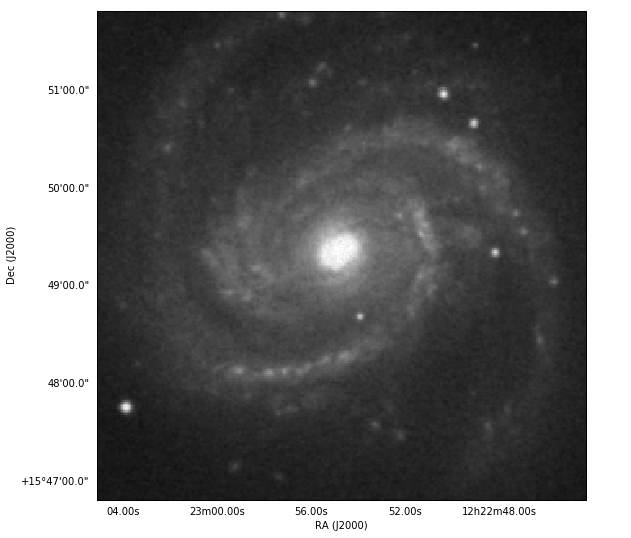

In [17]:
opt = hdulist[0] 
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()

In [18]:

from astropy.wcs import WCS
from matplotlib.patches import Circle
ra=opt.header['CRVAL1']
dec=opt.header['CRVAL2']
mywcs=WCS(opt.header)
max_radius=0.09

def select_radius(radius=max_radius):
    ax=plt.subplot(111,projection=mywcs)
    ax.imshow(opt.data,cmap="gray",origin='lower')
    cc=Circle((ra,dec),radius=radius,edgecolor="green",facecolor="none",transform=ax.get_transform('fk5'))
    ax.add_patch(cc)
    
mycirc=interact(select_radius,radius=(0.0,max_radius,max_radius/1000))

A Jupyter Widget

In [32]:
limits = mycirc.widget.kwargs
rad    = limits['radius']
print(ra,dec)
rad

185.728 15.8218


0.03618

In [33]:
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs(keywords=['GAIA'])
for key,item in catalog_list.items():
    print(key+" : "+item.description)

I/324 : The Initial Gaia Source List (IGSL) (Smart, 2013)
I/337 : Gaia DR1 (Gaia Collaboration, 2016)
I/339 : Hot Stuff for One Year (HSOY) (Altmann+, 2017)
I/340 : UCAC5 Catalogue (Zacharias+ 2017)
VI/137 : GaiaSimu Universe Model Snapshot (Robin+, 2012)
J/ApJ/811/85 : RVs & V-band LCs of probable members of Cyg OB2 (Kiminki+, 2015)
J/ApJ/831/L6 : Eclipsing binary parallaxes with Gaia data (Stassun+, 2016)
J/ApJ/832/L18 : Gaia's DR1 parallaxes vs previous measurements (Jao+, 2016)
J/ApJ/833/119 : Distances of Gaia DR1 TGAS sources (Astraatmadja+, 2016)
J/A+A/366/1003 : 8500-8750{AA} high resolution spectroscopy. III. (Munari+, 2001)
J/A+A/406/751 : Close encounters of asteroids 2003-2020 (Fienga+, 2003)
J/A+A/406/995 : 8500-8750{AA} high resolution spectroscopy. IV. (Marrese+, 2003)
J/A+A/520/A113 : VLBI detection of 398 extragalactic radio sources (Bourda+, 2010)
J/A+A/523/A48 : Gaia photometry (Jordi+, 2010)
J/A+A/526/A102 : VLBI imaging of 105 extragalactic radio sources (Bourda+, 

In [40]:
from astropy.coordinates import SkyCoord
import astropy.units as u

c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
#res=Vizier.query_region(c, radius=rad*u.deg, catalog='J/A+A/601/A19')
res=Vizier.query_region(c, radius=rad*u.deg, catalog='I/337')

In [41]:
restab=res[0]
#restab=res[0]
restab.show_in_notebook()
#restab

idx,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,pmRA,pmDE,RADEcor,Dup,__FG_,e__FG_,__Gmag_,Var
,deg,mas,deg,mas,,mas,mas / yr,mas / yr,,,e-/s,e-/s,mag,
0,185.7381227640,4.936,15.8019286598,3.374,3945390050828621056,--,--,--,-0.832,1,211,2.497,19.714,NOT_AVAILABLE
1,185.7461790790,48.893,15.8020492870,15.002,3945390149615599488,--,--,--,-0.939,0,166.3,3.524,19.972,NOT_AVAILABLE
2,185.7477853061,54.062,15.8152513394,26.222,3945390153907852032,--,--,--,-0.974,0,190,3.344,19.828,NOT_AVAILABLE
3,185.7493264663,43.634,15.8153906916,13.363,3945390153907852288,--,--,--,-0.898,1,129.7,3.444,20.242,NOT_AVAILABLE
4,185.7610081654,0.842,15.8251025328,0.583,3945390183975337984,--,--,--,-0.825,0,465.3,3.111,18.855,NOT_AVAILABLE
5,185.7602402653,1.023,15.8141218175,0.644,3945390188267574656,--,--,--,-0.832,0,303.8,2.25,19.318,NOT_AVAILABLE
6,185.7547099397,18.597,15.8133937553,7.070,3945390188268042496,--,--,--,-0.988,0,139.6,2.659,20.162,NOT_AVAILABLE
7,185.7046419813,1.077,15.7980288546,0.835,3945576211891358208,--,--,--,-0.831,0,370.4,3.398,19.103,NOT_AVAILABLE
8,185.7249346415,0.286,15.8110037272,0.221,3945577719426402304,--,--,--,-0.838,0,4131,11.52,16.485,NOT_AVAILABLE


INFO: Auto-setting vmin to  2.697e+03 [aplpy.core]
INFO: Auto-setting vmax to  2.446e+04 [aplpy.core]


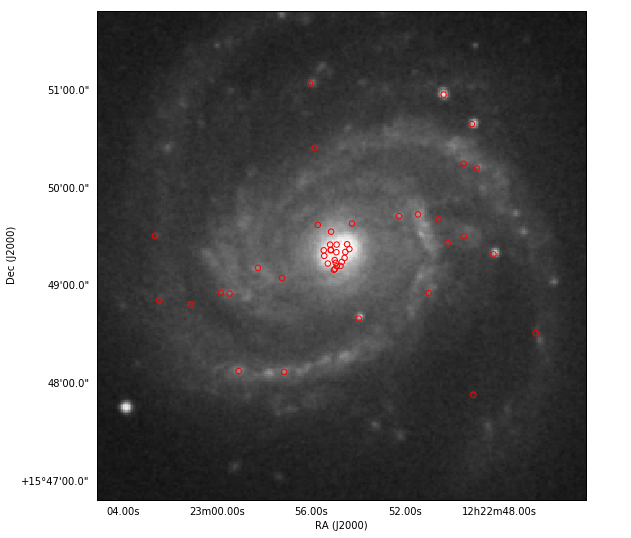

In [42]:
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()
#fig.show_markers(restab['ra'],restab['dec'])
fig.show_markers(restab['RA_ICRS'],restab['DE_ICRS'])

### With ALMA

In [45]:
res=SkyView.get_image_list(position='Galactic Center',survey=['NVSS'])
res

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv15372982969808.fits']

INFO: Auto-setting vmin to -1.796e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.434e+00 [aplpy.core]


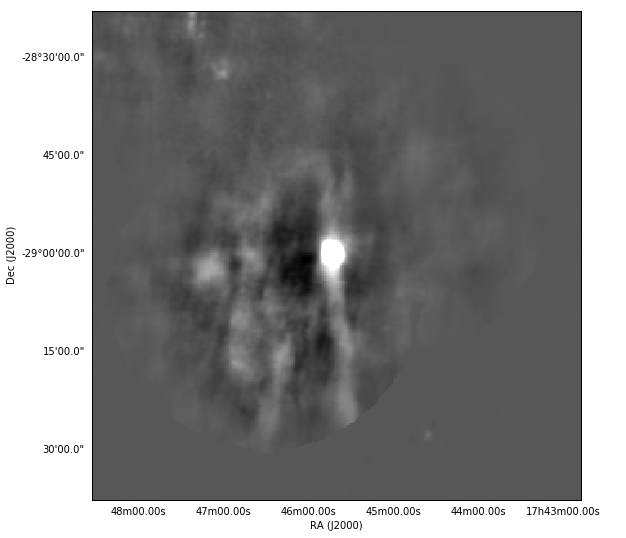

In [56]:
%matplotlib inline
urllib.request.urlretrieve(res[0],'opt.fits')
#urllib.urlretrieve(res[0],'opt.fits')
hdulist = fits.open("opt.fits")
opt = hdulist[0] 
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()

In [58]:
mycirc=interact(select_radius,radius=(0.0,0.9,0.9/100))

A Jupyter Widget

In [52]:
limits = mycirc.widget.kwargs
ra=opt.header['CRVAL1']
dec=opt.header['CRVAL2']
rad    = limits['radius']
print(ra,dec)
rad

266.417 -29.0078


0.0279

In [53]:
from astropy.vo.client import vos_catalog
catalog=vos_catalog.VOSCatalog.create("ChiVO ALMA",
                                      "http://vo.chivo.cl/archive_alma/q/scs-archive-alma/scs.xml?")
catalog.dumps()

'{\n    "title": "ChiVO ALMA",\n    "url": "http://vo.chivo.cl/archive_alma/q/scs-archive-alma/scs.xml?"\n}'

In [54]:
res=vos_catalog.call_vo_service('conesearch_good',
                            catalog_db=catalog,
                            kwargs={'RA': ra, 'DEC': dec,'SR': rad})

Trying http://vo.chivo.cl/archive_alma/q/scs-archive-alma/scs.xml?


VOSError: None of the available catalogs returned valid results.

In [28]:
almatab=res.to_table()
almatab.show_in_notebook()

idx,obsURL,project_code,source_name,s_ra,s_dec,band,spatial_resolution,frequency_resolution,integration,release_date,frequency_support,velocity_resolution,pol_products,observation_date,pi_name,pwv,group_ous_id,member_ous_id,asdm_uid,project_title,project_type,scan_intent,largest_angular_scale,qa2_status,pub
0,http://vo.chivo.cl:9000/tarball?asdm=uid://A002/Xa25bbf/Xc8cf&mous=uid://A001/X197/X33,2013.1.01242.S,SiO_15_16,266.416,-29.017600000000002,7.0,0.26793301,488.28101,151.2,2016-11-23,"[289.54..289.78GHz,976.56kHz,null]_U_[290.52..290.76GHz,976.56kHz,null]_U_[291.14..291.37GHz,976.56kHz,null]_U_[291.28..291.51GHz,976.56kHz,null]_U_[291.49..292.43GHz,976.56kHz,null]_U_[300.74..300.97GHz,976.56kHz,null]_U_[303.47..304.41GHz,488.28kHz,null]",973.12201,XX_YY,2015-06-08_03:41:01,"Yusef-Zadeh,_Farhad",0.4868778,uid://A001/X197/X32,uid://A001/X197/X33,uid://A002/Xa25bbf/Xc8cf,SiO_Observations_of_the_Circumnuclear_Molecular_Ring_and_Its_Interior,S,TARGET,15.236022735724893,Y,0.0
1,http://vo.chivo.cl:9000/tarball?asdm=uid://A002/Xa77ec0/X26e&mous=uid://A001/X197/X27,2013.1.01242.S,Circumnuclear_Ring,266.416,-29.0124,3.0,0.48200601,244.14101,124.993,2016-12-07,"[84.40..84.64GHz,244.14kHz,null]_U_[86.73..86.96GHz,244.14kHz,null]_U_[96.50..96.97GHz,488.28kHz,null]_U_[99.61..99.84GHz,244.14kHz,null]",854.23297,XX_YY,2015-08-06_00:59:26,"Yusef-Zadeh,_Farhad",4.1887031,uid://A001/X197/X26,uid://A001/X197/X27,uid://A002/Xa77ec0/X26e,SiO_Observations_of_the_Circumnuclear_Molecular_Ring_and_Its_Interior,S,TARGET,250.92385860193491,Y,0.0
2,http://vo.chivo.cl:9000/tarball?asdm=uid://A002/Xa25bbf/Xc8cf&mous=uid://A001/X197/X33,2013.1.01242.S,SiO_17,266.42200000000003,-29.017099999999999,7.0,0.26793301,488.28101,151.2,2016-11-23,"[289.54..289.78GHz,976.56kHz,null]_U_[290.52..290.76GHz,976.56kHz,null]_U_[291.14..291.37GHz,976.56kHz,null]_U_[291.28..291.51GHz,976.56kHz,null]_U_[291.49..292.43GHz,976.56kHz,null]_U_[300.74..300.97GHz,976.56kHz,null]_U_[303.47..304.41GHz,488.28kHz,null]",973.12201,XX_YY,2015-06-08_03:41:01,"Yusef-Zadeh,_Farhad",0.4868778,uid://A001/X197/X32,uid://A001/X197/X33,uid://A002/Xa25bbf/Xc8cf,SiO_Observations_of_the_Circumnuclear_Molecular_Ring_and_Its_Interior,S,TARGET,15.2372831514159,Y,0.0
3,http://vo.chivo.cl:9000/tarball?asdm=uid://A002/Xa25bbf/Xc8cf&mous=uid://A001/X197/X33,2013.1.01242.S,SiO_30_31,266.41000000000003,-29.011099999999999,7.0,0.26793599,488.28101,151.2,2016-11-23,"[289.54..289.78GHz,976.56kHz,null]_U_[290.52..290.76GHz,976.56kHz,null]_U_[291.14..291.37GHz,976.56kHz,null]_U_[291.28..291.51GHz,976.56kHz,null]_U_[291.49..292.43GHz,976.56kHz,null]_U_[300.74..300.97GHz,976.56kHz,null]_U_[303.47..304.41GHz,488.28kHz,null]",973.12201,XX_YY,2015-06-08_03:41:01,"Yusef-Zadeh,_Farhad",0.4868778,uid://A001/X197/X32,uid://A001/X197/X33,uid://A002/Xa25bbf/Xc8cf,SiO_Observations_of_the_Circumnuclear_Molecular_Ring_and_Its_Interior,S,TARGET,15.233305658622868,Y,0.0
4,http://vo.chivo.cl:9000/tarball?asdm=uid://A002/X83b318/X971&mous=uid://A001/X122/X160,2013.1.01058.S,SgrA_star,266.41699999999997,-29.0107,7.0,3.60624,976.56201,2373.361,2016-09-23,"[344.78..346.84GHz,976.56kHz,null]_U_[346.17..348.22GHz,976.56kHz,null]_U_[356.21..358.26GHz,976.56kHz,null]_U_[356.91..358.96GHz,976.56kHz,null]",831.138,XX_YY,2014-06-09_07:57:38,"Goicoechea,_Javier",--,uid://A001/X122/X15d,uid://A001/X122/X160,uid://A002/X83b318/X971,Irradiated_Shocks_and_Ionisation_Sources_in_the_Central_Parsec_of_the_Milky_Way,S,TARGET,196.10165749058791,Y,0.0
5,http://vo.chivo.cl:9000/tarball?asdm=uid://A002/Xa16f89/X10bb&mous=uid://A001/X121/X2de,2013.1.00857.S,Circumnuclear_Disk,266.41399999999999,-29.009499999999999,6.0,20.1436,1953.12,11354.112,2016-10-16,"[251.50..253.49GHz,1953.12kHz,null]_U_[253.74..255.73GHz,1953.12kHz,null]_U_[265.74..267.74GHz,1953.12kHz,null]_U_[268.73..270.72GHz,1953.12kHz,null]",2245.6599,XX_YY,2015-05-24_01:31:48,"Mills,_Elisabeth",1.3583895,uid://A001/X121/X2d9,uid://A001/X121/X2de,uid://A002/Xa16f89/X10bb,The_Density_(and_

INFO: Auto-setting vmin to -1.796e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.434e+00 [aplpy.core]


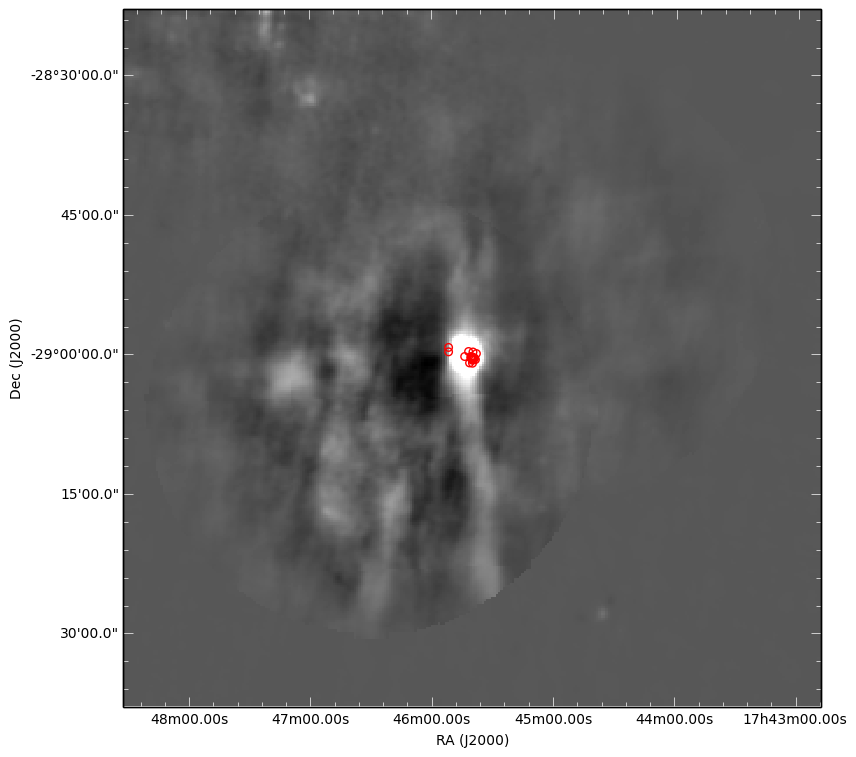

In [30]:
#%matplotlib notebook
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()
fig.show_markers(almatab['s_ra'],almatab['s_dec'])

In [ ]:
# http://vo.chivo.cl:9000/tarball?asdm=uid://A002/Xa657ad/Xd3b&mous=uid://A001/X122/X2b